In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("loan.csv")

C:\Users\brand\AppData\Local\Continuum\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df["dateIssued"] = pd.to_datetime(df["issue_d"])

In [4]:
def getClass(status):
    if status=="Charged Off" or status=="Default" or status=="Does not meet the credit policy. Status:Charged Off" or status=="In Grace Period" or status=="Late (16-30 days)" or status=="Late (31-120 days)":
        return 0
    else:
        return 1
df["goodLoan"] = df["loan_status"].apply(lambda x: getClass(x))

In [5]:
midWest = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
northEast = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']
southEast = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
southWest = ['AZ', 'TX', 'NM', 'OK']

df['region'] = np.nan

def getRegion(state):
    if state in west:
        return 'West'
    elif state in southWest:
        return 'SouthWest'
    elif state in southEast:
        return 'SouthEast'
    elif state in midWest:
        return 'MidWest'
    elif state in northEast:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(lambda x: getRegion(x))

In [6]:
dfDateRegion = df.groupby(["dateIssued", "region"], as_index=False).sum()

dfDateRegion['monthYear'] = [month.to_period('M') for 
                          month in dfDateRegion['dateIssued']] #get year-month

dfDateRegion = dfDateRegion.groupby(['monthYear', 'region'], as_index=False).sum()
dfDateRegionFilter = dfDateRegion[["region", "monthYear", "loan_amnt"]]
dfGroupDateRegion = dfDateRegionFilter.groupby(['monthYear', 'region']).loan_amnt.sum()

<Figure size 1080x432 with 0 Axes>

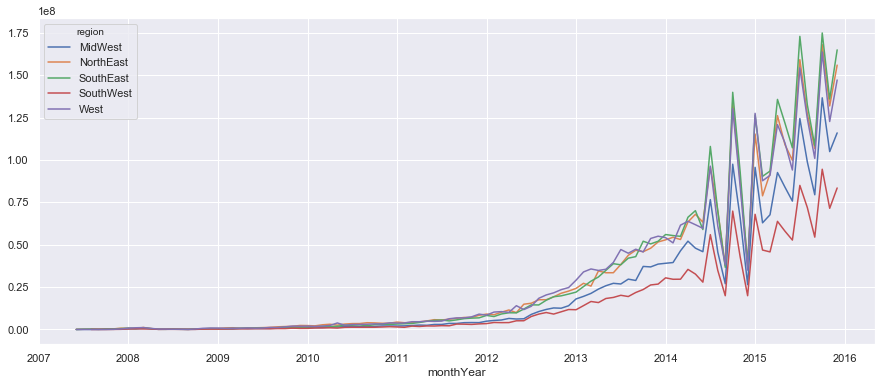

In [8]:
plt.figure(figsize=(15,6))
dfGroupDateRegion.unstack().plot(stacked=False, legend=True, figsize=(15,6))
#sns.lineplot(x="monthYear", y="loan_amnt", hue="region", data=dfDateRegionFilter)

# 1. EDA

Text(0.5,1,'Frequency of Good vs. Bad Loans')

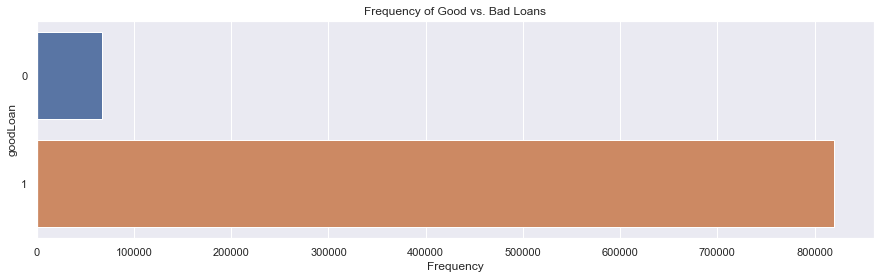

In [114]:
dfClassGrouped = df.groupby("goodLoan")["id"].count()
plt.figure(figsize=(15, 4))
sns.barplot(dfClassGrouped.values, dfClassGrouped.index, orient="h")
plt.xlabel("Frequency")
plt.title("Frequency of Good vs. Bad Loans")

In [115]:
dfClassGrouped.iloc[0]/dfClassGrouped.sum()

0.07598669790472842

Notice that bad loans only account for under 10% of total loans. This is particularly problematic if we run standard classification techniques, so implementing different sampling techniques will be required to optimize model performance. Before we do so, however, we will perform some basic EDA to answer where and why bad loans occur.

## Analysis by Region and State

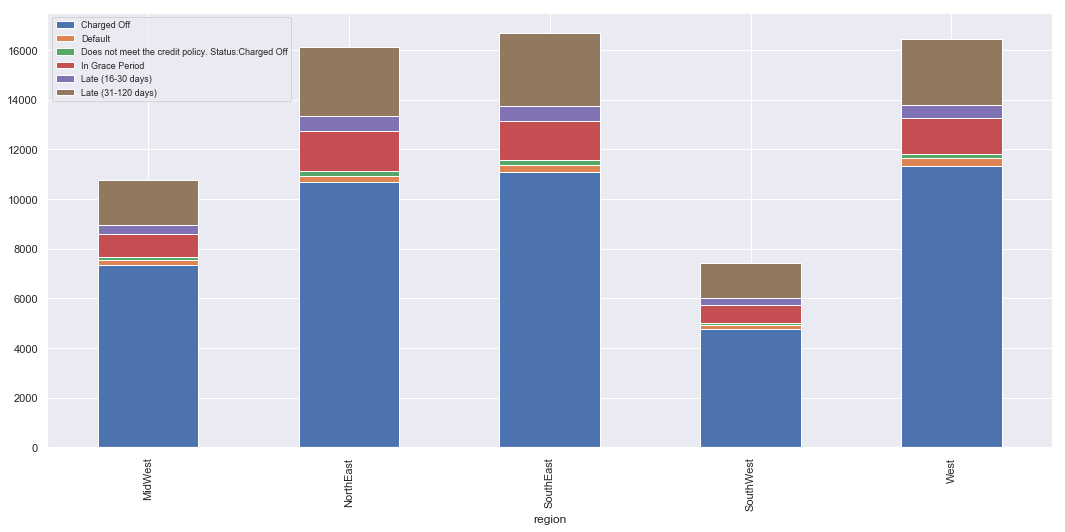

In [145]:
dfBadLoans = df[df["goodLoan"]==0]
dfClassGrouped = dfBadLoans.groupby(["region", "loan_status"])["id"].count()
dfClassGrouped.unstack().plot.bar(stacked=True, figsize=(18, 8))
plt.legend(loc=2, prop={'size': 9})

In [167]:
dfRegionGrouped = df.groupby(["region", "goodLoan"])["id"].count()
dfRegionGrouped = dfRegionGrouped.unstack()
dfRegionGrouped["prop0"] = dfRegionGrouped[0]/(dfRegionGrouped[0]+dfRegionGrouped[1])
dfRegionGrouped["prop1"] = 1-dfRegionGrouped["prop0"]
dfRegionGrouped[["prop0", "prop1"]]

goodLoan,prop0,prop1
region,,
MidWest,0.069522,0.930478
NorthEast,0.078929,0.921071
SouthEast,0.077705,0.922295
SouthWest,0.070830,0.929170
West,0.078723,0.921277


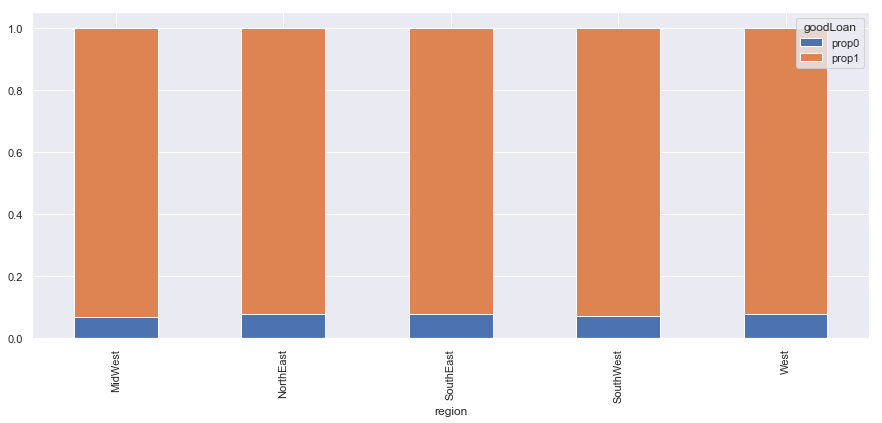

In [168]:
dfRegionGrouped[["prop0", "prop1"]].plot.bar(stacked=True, figsize=(15, 6))

Not too much discrepancy between the number of bad loans between region.

In [181]:
dfStatesLoan = df.groupby("addr_state")["loan_amnt"].agg([("loanMedian", "median"), ("loanAvg", "mean"), ("loanCount", "count")])
dfStatesLoan.sort_values("loanMedian", ascending=False).head()

,loanMedian,loanAvg,loanCount
addr_state,,,
AK,15500.0,16770.090703,2205
MA,14400.0,15679.331569,20593
VA,14400.0,15662.618549,26255
TX,14400.0,15591.239211,71138
ND,14400.0,15547.599165,479


(12000, 18000)

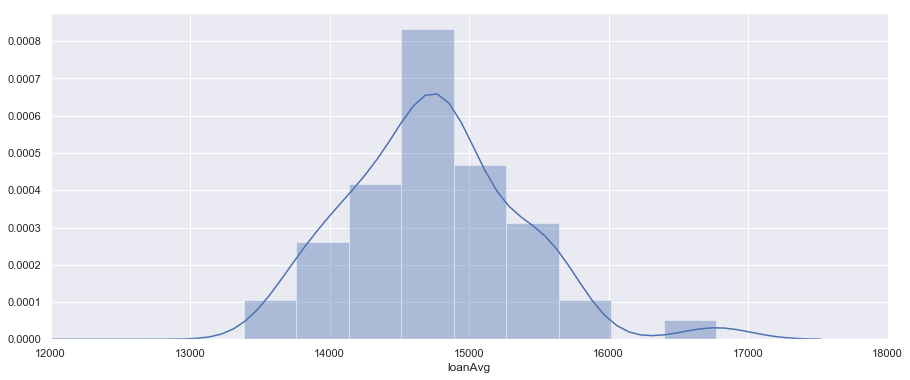

In [192]:
plt.figure(figsize=(15, 6))
sns.distplot(dfStatesLoan["loanAvg"])
plt.xlim((12000, 18000))

Most loans hover around $14000-15000. Not a huge significant difference from state to state...

In [182]:
dfStatesLoan.sort_values("loanCount", ascending=False).head()

,loanMedian,loanAvg,loanCount
addr_state,,,
CA,12700.0,14655.568381,129517
NY,12500.0,14536.376306,74086
TX,14400.0,15591.239211,71138
FL,12000.0,13932.700008,60935
IL,14000.0,15195.299639,35476


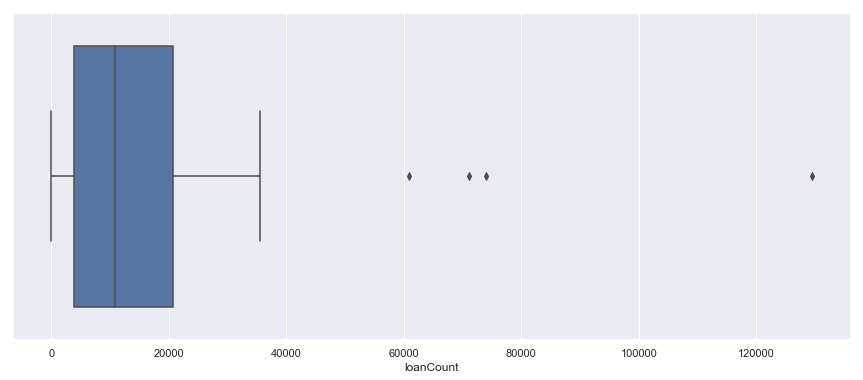

In [193]:
plt.figure(figsize=(15, 6))
sns.boxplot(dfStatesLoan["loanCount"])

There do seem to be a couple of states (top 4) that have significantly higher loan counts compared to other states. We need to analyze whether or not the proportion of bad loans in these states are inflated as well.

In [203]:
dfStateBadLoan = df.groupby("addr_state")["goodLoan"].agg([("sumGoodLoan", "sum"), ("totalLoans", "count")])
dfStateBadLoan["sumBadLoan"] = dfStateBadLoan["totalLoans"] - dfStateBadLoan["sumGoodLoan"]
dfStateBadLoan["propBadLoan"] = dfStateBadLoan["sumBadLoan"]/dfStateBadLoan["totalLoans"]

propBadLoan = np.mean(dfStateBadLoan["propBadLoan"])
dfStateBadLoan["devMean"] = dfStateBadLoan["propBadLoan"]-propBadLoan

dfStateBadLoan.sort_values("propBadLoan", ascending=False).head()

,sumGoodLoan,totalLoans,sumBadLoan,propBadLoan,devMean
addr_state,,,,,
IA,11,14,3,0.214286,0.142160
NV,11270,12443,1173,0.094270,0.022144
HI,4143,4570,427,0.093435,0.021310
AL,10207,11200,993,0.088661,0.016535
NY,67797,74086,6289,0.084888,0.012762


In [209]:
dfStateBadLoan = dfStateBadLoan.reset_index()
dfStateBadLoan[dfStateBadLoan["addr_state"].isin(["CA", "NY", "TX", "FL"])]

,index,addr_state,sumGoodLoan,totalLoans,sumBadLoan,propBadLoan,devMean
4,4,CA,118999,129517,10518,0.081209,0.009084
9,9,FL,55787,60935,5148,0.084483,0.012358
34,34,NY,67797,74086,6289,0.084888,0.012762
43,43,TX,66379,71138,4759,0.066898,-0.005228


Not too much difference from the average proportion of bad loans from other states...

## Analysis by Income Level

In [7]:
df = df.dropna(subset=["annual_inc"])

In [8]:
dictIncome = {}
for i in range(1,100):
    dictIncome[i] = np.percentile(df["annual_inc"], i)
seriesIncome = pd.Series(dictIncome)

Text(0,0.5,'Annual Income')

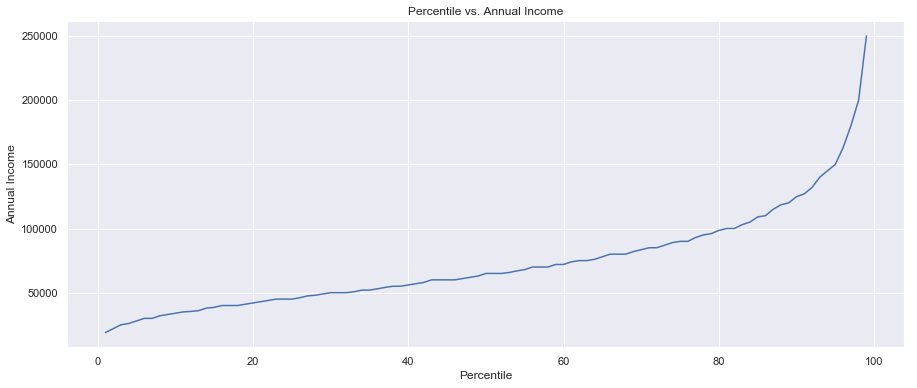

In [243]:
plt.figure(figsize=(15, 6))
sns.lineplot(list(dictIncome.keys()), list(dictIncome.values()))
plt.title("Percentile vs. Annual Income")
plt.xlabel("Percentile")
plt.ylabel("Annual Income")

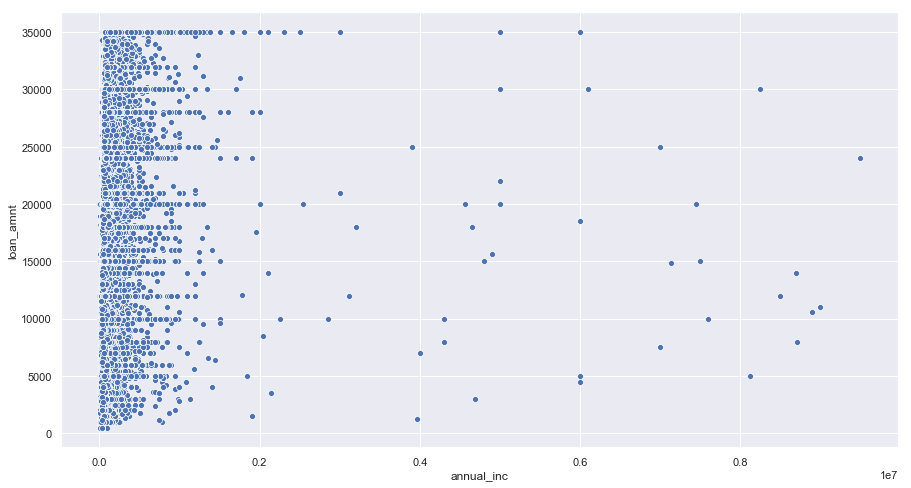

In [245]:
plt.figure(figsize=(15, 8))
sns.scatterplot(df["annual_inc"], df["loan_amnt"])

Can't really get much analysis with this. Perhaps turn annual income into a categorical variable: <br>
Low income: 0-50K<br>
Middle income: 50-100K<br>
High income: 100K+<br>

In [9]:
def getIncomeCat(income):
    if income<50000:
        return "Low"
    elif income>=50000 and income<100000:
        return "Middle"
    else: 
        return "High"
df["incomeCat"] = df["annual_inc"].apply(lambda x: getIncomeCat(x))

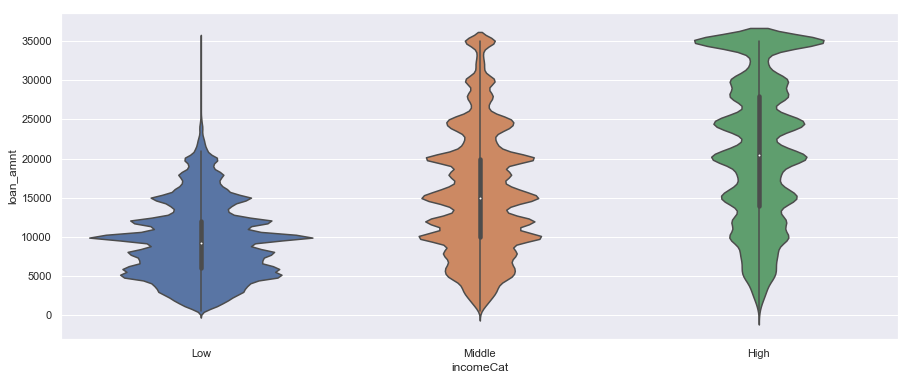

In [256]:
plt.figure(figsize=(15, 6))
sns.violinplot(x="incomeCat", y="loan_amnt", data=df)

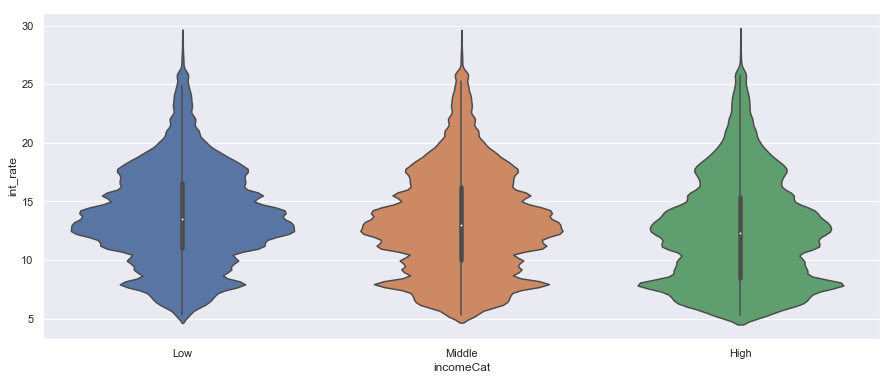

In [259]:
plt.figure(figsize=(15, 6))
sns.violinplot(x="incomeCat", y="int_rate", data=df)

Text(0.5,1,'Percentage of Good/Bad Loans by Income Category')

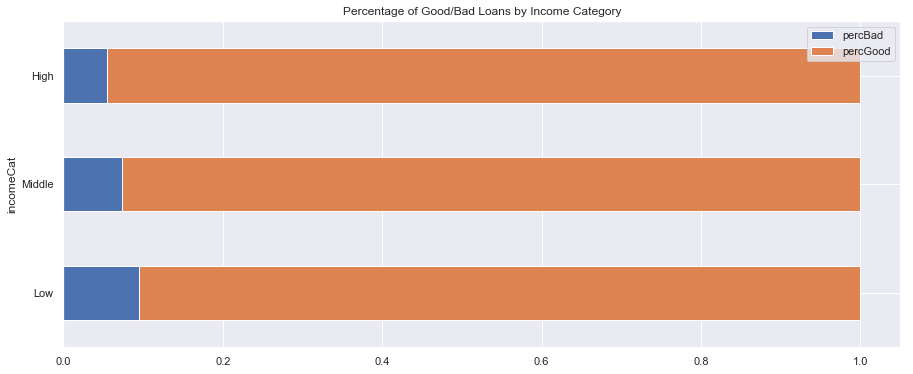

In [275]:
dfIncomeGrouped = df.groupby("incomeCat")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfIncomeGrouped["percBad"] = (dfIncomeGrouped["totalLoans"]-dfIncomeGrouped["goodLoans"])/dfIncomeGrouped["totalLoans"]
dfIncomeGrouped["percGood"] = 1-dfIncomeGrouped["percBad"]
dfIncomeGrouped = dfIncomeGrouped.sort_values("percBad", ascending=False)
dfIncomeGrouped[["percBad", "percGood"]].plot.barh(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Income Category")

In [276]:
dfIncomeGrouped

,totalLoans,goodLoans,percBad,percGood
incomeCat,,,,
Low,260560,235932,0.094519,0.905481
Middle,451921,418768,0.073360,0.926640
High,174894,165246,0.055165,0.944835


There is a clear distinction between the different income levels for good/bad loans. Lower income individuals tend to have get smaller amounts of loans, but have a higher percentage of bad loans with higher interest rates compared to middle/higher income individuals.

## Analysis by Credit Score

In [281]:
dfCreditGrouped = df.groupby("grade")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfCreditGrouped["percBad"] = (dfCreditGrouped["totalLoans"]-dfCreditGrouped["goodLoans"])/dfCreditGrouped["totalLoans"]
dfCreditGrouped["percGood"] = 1-dfCreditGrouped["percBad"]
dfCreditGrouped = dfCreditGrouped.sort_values("percBad", ascending=False)
dfCreditGrouped

,totalLoans,goodLoans,percBad,percGood
grade,,,,
G,5489,4220,0.231190,0.768810
F,23046,18663,0.190185,0.809815
E,70705,60960,0.137826,0.862174
D,139542,123683,0.113650,0.886350
C,245860,226806,0.077499,0.922501
B,254535,241079,0.052865,0.947135
A,148198,144535,0.024717,0.975283


Text(0.5,1,'Percentage of Good/Bad Loans by Income Category')

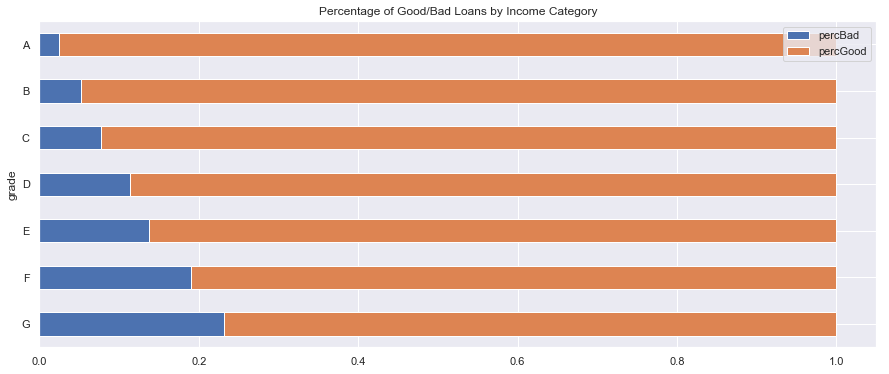

In [285]:
dfCreditGrouped[["percBad", "percGood"]].plot.barh(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Income Category")

In [287]:
dfSubCreditGrouped = df.groupby("sub_grade")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfSubCreditGrouped["percBad"] = (dfSubCreditGrouped["totalLoans"]-dfSubCreditGrouped["goodLoans"])/dfSubCreditGrouped["totalLoans"]
dfSubCreditGrouped["percGood"] = 1-dfSubCreditGrouped["percBad"]
dfSubCreditGrouped = dfSubCreditGrouped.sort_values("percBad", ascending=False)
dfSubCreditGrouped.head()

,totalLoans,goodLoans,percBad,percGood
sub_grade,,,,
G5,576,422,0.267361,0.732639
F5,2594,1988,0.233616,0.766384
G1,1871,1439,0.230893,0.769107
G3,981,755,0.230377,0.769623
G2,1398,1086,0.223176,0.776824


Text(0.5,1,'Percentage of Good/Bad Loans by Income Category')

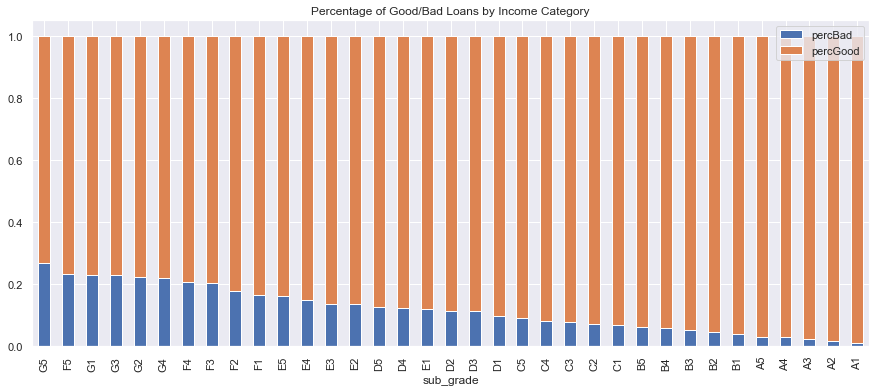

In [290]:
dfSubCreditGrouped[["percBad", "percGood"]].plot.bar(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Income Category")

Our analysis supports our intuition, the higher the credit grade, the smaller the % of bad loans given.

## Analysis on Purpose

In [299]:
dfPurposeGrouped = df.groupby("purpose")["goodLoan"].agg([("totalLoans", "count"), ("goodLoans", "sum")])
dfPurposeGrouped["percBad"] = (dfPurposeGrouped["totalLoans"]-dfPurposeGrouped["goodLoans"])/dfPurposeGrouped["totalLoans"]
dfPurposeGrouped["percGood"] = 1-dfPurposeGrouped["percBad"]
dfPurposeGrouped = dfPurposeGrouped.sort_values("percBad", ascending=False)
dfPurposeGrouped

,totalLoans,goodLoans,percBad,percGood
purpose,,,,
educational,423,335,0.208038,0.791962
small_business,10377,8596,0.171630,0.828370
renewable_energy,575,503,0.125217,0.874783
wedding,2347,2058,0.123136,0.876864
house,3707,3290,0.112490,0.887510
moving,5414,4807,0.112117,0.887883
other,42890,38727,0.097062,0.902938
medical,8540,7736,0.094145,0.905855
vacation,4736,4334,0.084882,0.915118


Text(0.5,1,'Percentage of Good/Bad Loans by Purpose')

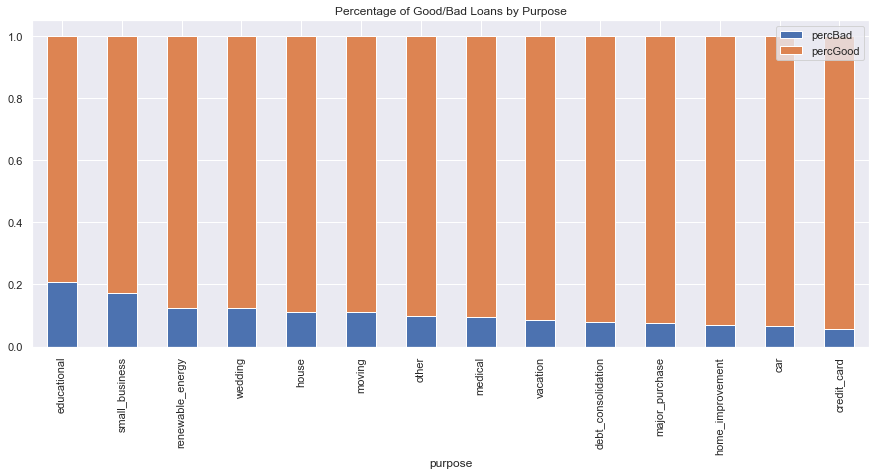

In [300]:
dfPurposeGrouped[["percBad", "percGood"]].plot.bar(stacked=True, figsize=(15, 6))
plt.title("Percentage of Good/Bad Loans by Purpose")

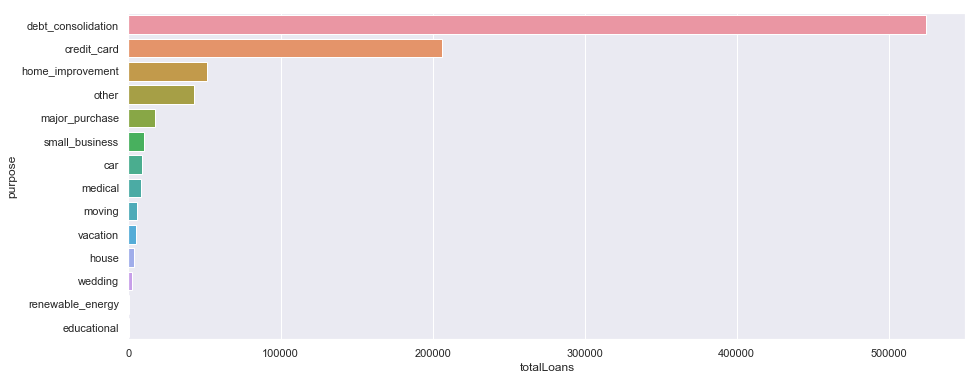

In [303]:
dfPurposeGrouped = dfPurposeGrouped.reset_index().sort_values("totalLoans", ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(y=dfPurposeGrouped["purpose"], x=dfPurposeGrouped["totalLoans"])

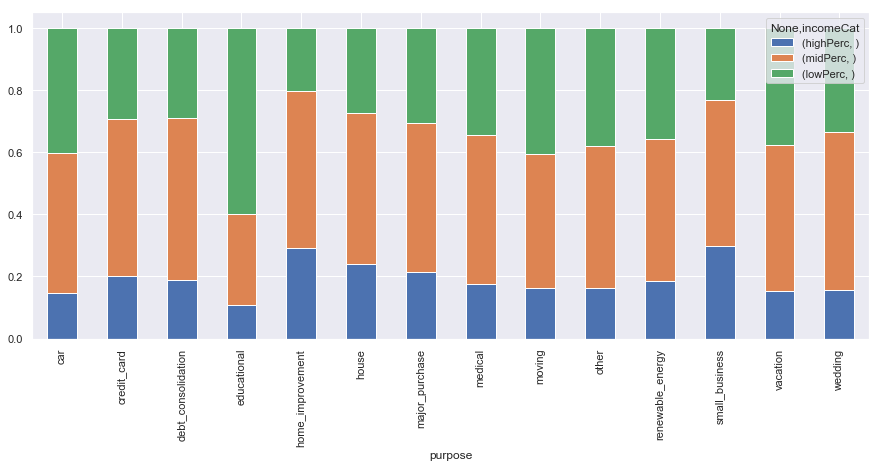

In [418]:
dfPurposeGrouped2 = dfPurposeGrouped.unstack()[["totalLoans"]]
dfPurposeGrouped2["highPerc"] = dfPurposeGrouped2["totalLoans"]["High"]/(dfPurposeGrouped2["totalLoans"]["High"]+dfPurposeGrouped2["totalLoans"]["Middle"]+dfPurposeGrouped2["totalLoans"]["Low"])
dfPurposeGrouped2["midPerc"] = dfPurposeGrouped2["totalLoans"]["Middle"]/(dfPurposeGrouped2["totalLoans"]["High"]+dfPurposeGrouped2["totalLoans"]["Middle"]+dfPurposeGrouped2["totalLoans"]["Low"])
dfPurposeGrouped2["lowPerc"] = dfPurposeGrouped2["totalLoans"]["Low"]/(dfPurposeGrouped2["totalLoans"]["High"]+dfPurposeGrouped2["totalLoans"]["Middle"]+dfPurposeGrouped2["totalLoans"]["Low"])
dfPurposeGrouped2[["highPerc", "midPerc", "lowPerc"]].plot.bar(stacked=True, figsize=(15, 6))

Educational and small business have the highest proportion of bad loans. However, the amount of educational loans is relatively low, but the amount of small business loans is quite substantial. Debt consolidation, home improvement, and credit card loans account for most of the total loans, but have relatively low bad loan rates. More individuals with lower income tend to take out loans related to small business and home improvement. Loans related to car, education, and vacations are taken out higher for higher income individauls 

## Analysis on Interest Rates

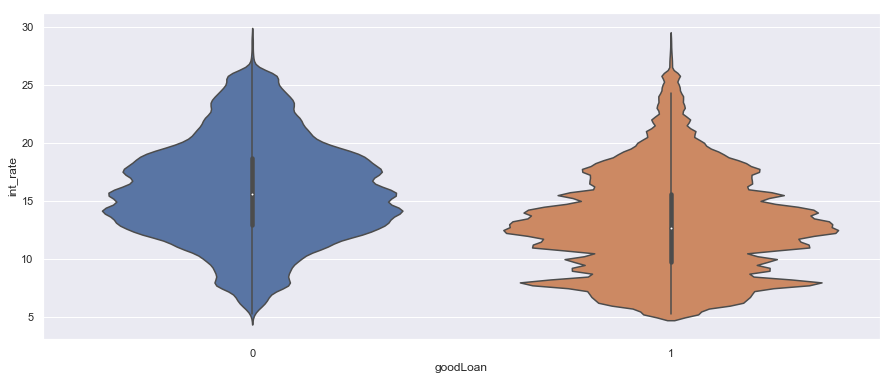

In [309]:
plt.figure(figsize=(15, 6))
sns.violinplot(y=df["int_rate"], x=df["goodLoan"])

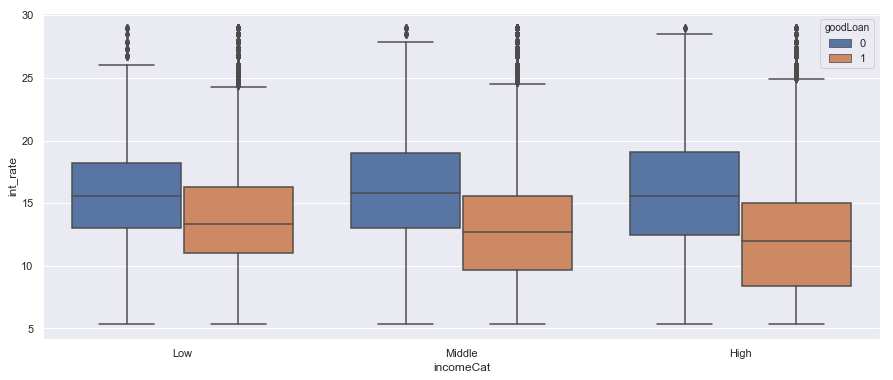

In [395]:
plt.figure(figsize=(15,6))
sns.boxplot("incomeCat", "int_rate", hue="goodLoan", data=df)

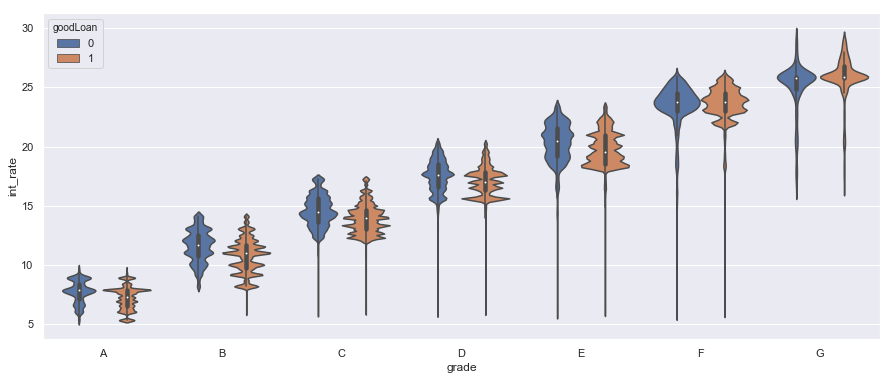

In [398]:
plt.figure(figsize=(15,6))
sns.violinplot("grade", "int_rate", hue="goodLoan", data=df, order=["A", "B", "C", "D", "E", "F", "G"])

A worse credit score tends to have higher interest rate, regardless if it's a good or bad loan.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

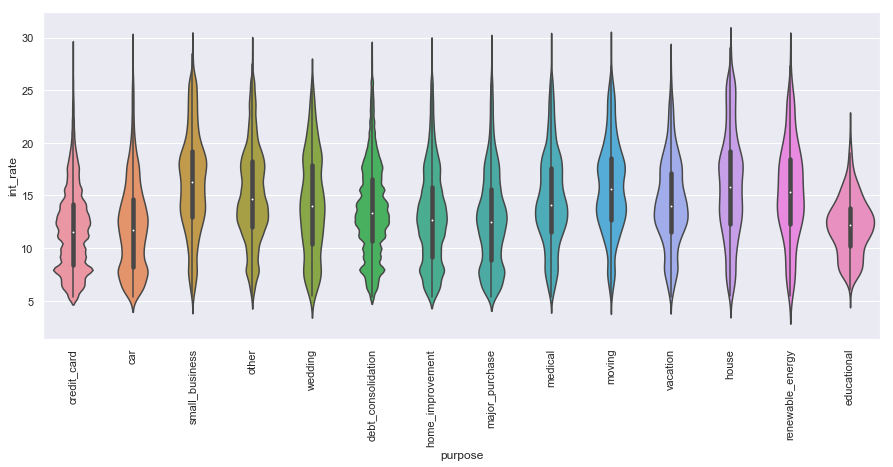

In [312]:
plt.figure(figsize=(15, 6))
sns.violinplot(y=df["int_rate"], x=df["purpose"])
plt.xticks(rotation=90)

Interest rates on bad loans are higher than good loans, and typically higher on small business loans. This may be attributed to the fact that small business loans have a higher percentage of bad loans taken out.

## Analysis on Trend

In [325]:
dfDatePurpose = df.groupby(["dateIssued", "purpose"], as_index=False).sum()

dfDatePurpose['monthYear'] = [month.to_period('M') for 
                          month in dfDatePurpose['dateIssued']] #get year-month

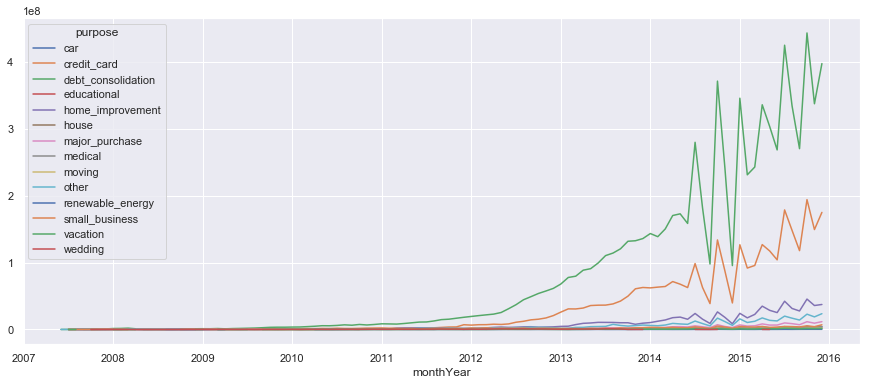

In [337]:
dfDatePurpose = dfDatePurpose.groupby(['monthYear', 'purpose'], as_index=False).mean()
dfDatePurposeFilter = dfDatePurpose[["purpose", "monthYear", "loan_amnt"]]
dfDatePurposeGrouped = dfDatePurposeFilter.groupby(["monthYear", "purpose"])["loan_amnt"].mean()
dfDatePurposeGrouped.unstack().plot(stacked=False, legend=True, figsize=(15,6))

In [10]:
df['monthYear'] = [month.to_period('M') for 
                          month in df['dateIssued']] #get year-month

In [349]:
dfBadLoansTrend = df.groupby(["monthYear"])["goodLoan"].agg([("total", "count"), ("good", "sum")])

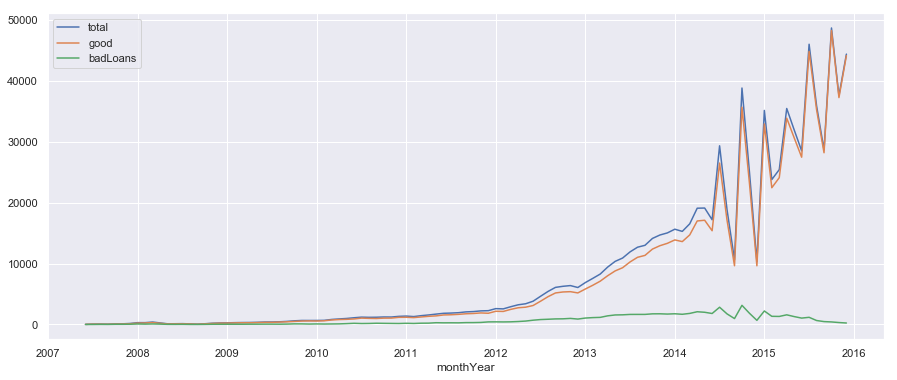

In [355]:
dfBadLoansTrend["badLoans"] = dfBadLoansTrend["total"] - dfBadLoansTrend["good"]
dfBadLoansTrend.plot(figsize=(15, 6))

In [363]:
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

C:\Users\Owner\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [364]:
dfIntRateTrend = df.groupby(["year", "goodLoan"])["int_rate"].agg([("median", "median")])

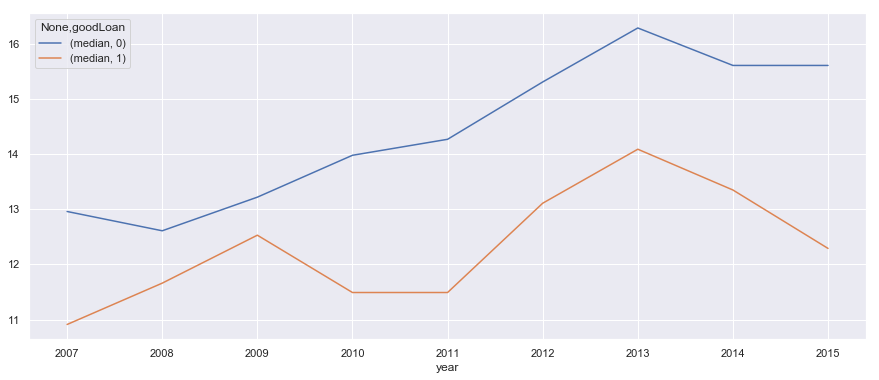

In [365]:
dfIntRateTrend.unstack().plot(figsize=(15, 6))

Interest rates see a spike for both good and bad loans in 2013. May be external factors causing this spike.

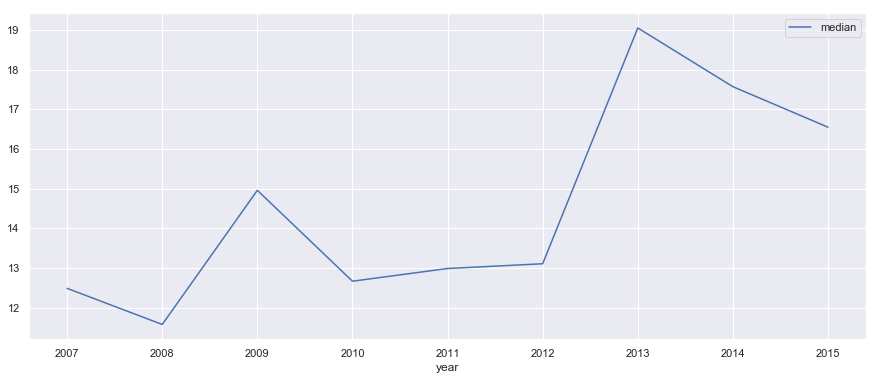

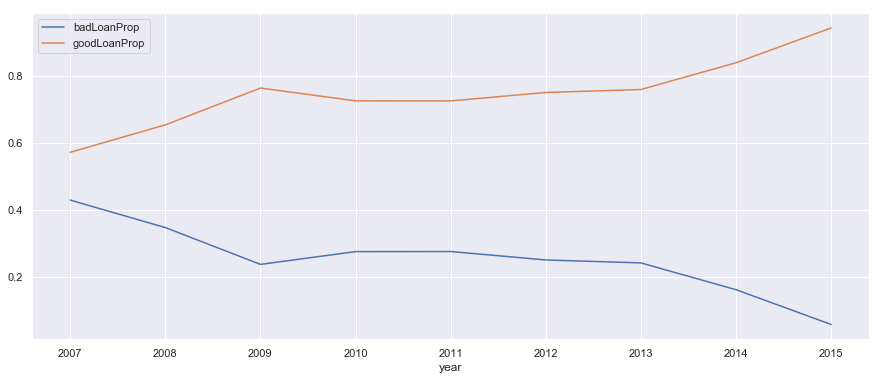

In [384]:
dfSmallBusinessInt = df[df["purpose"]=="small_business"]
dfSmallBusinessIntGrouped = dfSmallBusinessInt.groupby("year")["int_rate"].agg([("median", "median")])
dfSmallBusinessCountGrouped = dfSmallBusinessInt.groupby("year")["goodLoan"].agg([("total", "count"), ("good", "sum")])
dfSmallBusinessCountGrouped["badLoans"] = dfSmallBusinessCountGrouped["total"]-dfSmallBusinessCountGrouped["good"]
dfSmallBusinessCountGrouped["badLoanProp"] = dfSmallBusinessCountGrouped["badLoans"]/dfSmallBusinessCountGrouped["total"]
dfSmallBusinessCountGrouped["goodLoanProp"] = dfSmallBusinessCountGrouped["good"]/dfSmallBusinessCountGrouped["total"]
dfSmallBusinessIntGrouped.plot(figsize=(15, 6))
dfSmallBusinessCountGrouped[["badLoanProp", "goodLoanProp"]].plot(figsize=(15, 6))

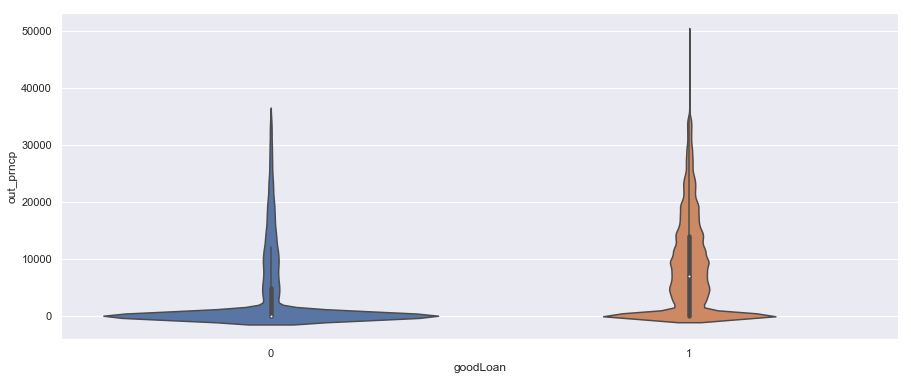

In [100]:
plt.figure(figsize=(15, 6))
sns.violinplot(df["goodLoan"], df["out_prncp"])

## 2. Classification of Good/Bad Loans

In [11]:
finaldf = df.copy()
"""
pub_rec - # of accounts client is delinquent
total_acc - # of credit lines the borrower has
delinq_2yrs - # of delinquencies in past 2 yrs
"""
finaldf = finaldf[['loan_amnt', "region", "incomeCat", 'term', 'int_rate', 'installment', 'grade',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
       'goodLoan', 'mths_since_last_major_derog', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
        'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
        'last_pymnt_amnt']]

In [12]:
finaldf["mths_since_last_delinq"] = finaldf["mths_since_last_delinq"].fillna(0)
finaldf["mths_since_last_record"] = finaldf["mths_since_last_record"].fillna(0)
finaldf["mths_since_last_major_derog"] = finaldf["mths_since_last_major_derog"].fillna(0)

finaldf["delinq_2yrs"] = finaldf.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.median()))
finaldf["inq_last_6mths"] = finaldf.groupby("region")["inq_last_6mths"].transform(lambda x: x.fillna(x.median()))
finaldf["total_acc"] = finaldf.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))
finaldf["pub_rec"] = finaldf.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
finaldf["open_acc"] = finaldf.groupby("region")["open_acc"].transform(lambda x: x.fillna(x.median()))
finaldf["revol_util"] = finaldf.groupby("region")["revol_util"].transform(lambda x: x.fillna(x.median()))

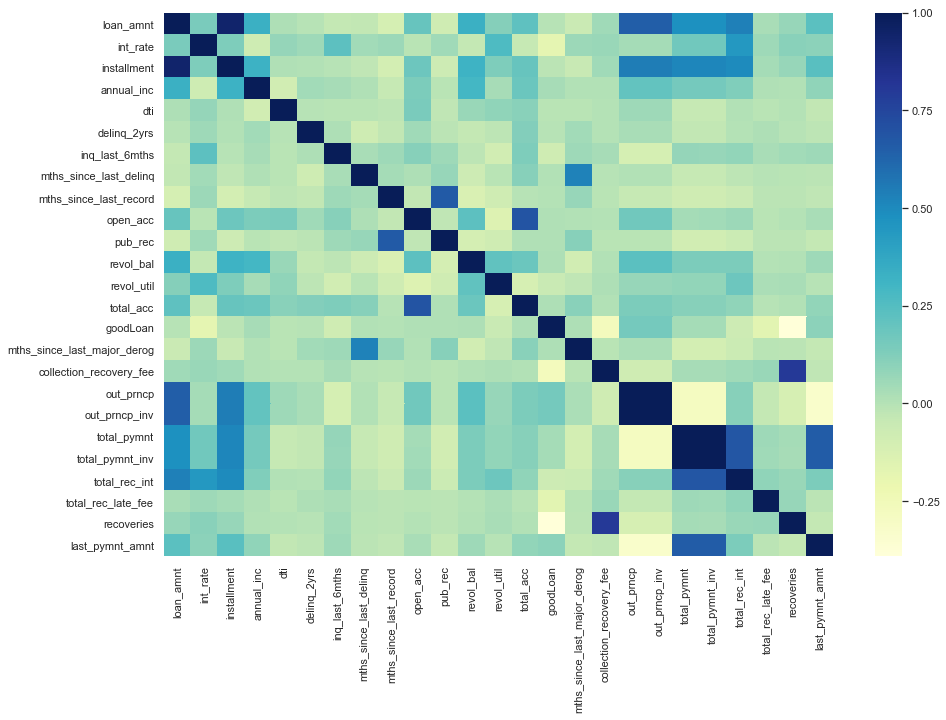

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(finaldf.corr(), cmap="YlGnBu")

In [13]:
catCols = ["region", "incomeCat", "term", "grade", "home_ownership", "verification_status", "pymnt_plan", "purpose"]
finaldf = pd.get_dummies(finaldf, drop_first=True)

In [14]:
y = finaldf["goodLoan"]
finaldf = finaldf.drop(["goodLoan"], axis=1)
X = finaldf

In [19]:
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
#from imblearn.metrics import classification_report_imbalanced

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, f_classif, chi2
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
#import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
#from xgboost import plot_importance
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import learning_curve
from scipy import stats
import lightgbm as lgb

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
clf = SGDClassifier()
clf.fit(X_train_sm, y_train_sm)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
y_pred = clf.predict(X_test)
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.74      0.64     22151
           1       0.98      0.95      0.97    270683

    accuracy                           0.94    292834
   macro avg       0.77      0.85      0.80    292834
weighted avg       0.95      0.94      0.94    292834



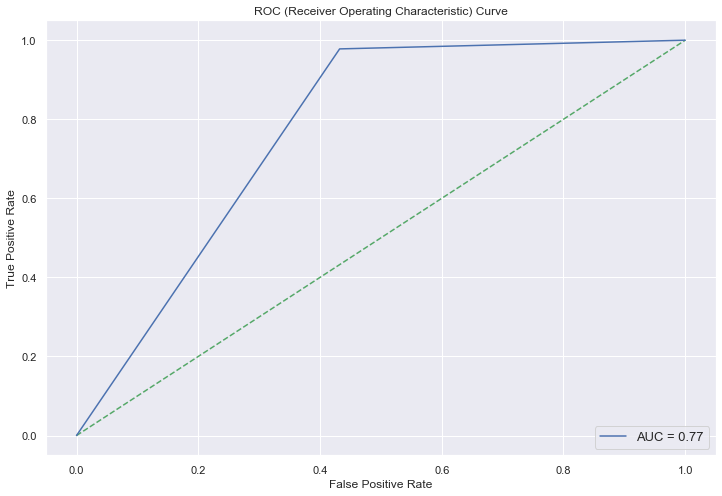

In [35]:
fpr, tpr, threshold = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1],'g--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 13})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.show()

In [27]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [19]:
selector = SelectKBest(f_classif, k="all").fit(X, y)
pVal = selector.pvalues_ #obtain p-value from F statistic
mapPVal = list(zip(pVal, X.columns)) #map column to its p-value
dfPVal = pd.Series({i[1]: i[0] for i in mapPVal}).reset_index().rename({"index": "feature", 0: "p-value"}, axis=1)
dfPVal.shape[0]

58

In [20]:
dfPVal = dfPVal[dfPVal["p-value"]<0.05].sort_values("p-value", ascending=True)
dfPVal['rank'] = np.arange(len(dfPVal))+1
dfPVal.head()

,feature,p-value,rank
28,incomeCat_Low,0.0,1
36,grade_G,0.0,2
35,grade_F,0.0,3
34,grade_E,0.0,4
33,grade_D,0.0,5


In [21]:
dfPVal.shape[0]

57

In [22]:
selector = SelectKBest(chi2, k="all").fit(X, y)
pVal = selector.pvalues_ #obtain p-value from F statistic
mapPVal = list(zip(pVal, X.columns)) #map column to its p-value
dfPVal = pd.Series({i[1]: i[0] for i in mapPVal}).reset_index().rename({"index": "feature", 0: "p-value"}, axis=1)
dfPVal.shape[0]

58

In [23]:
dfPVal = dfPVal[dfPVal["p-value"]<0.05].sort_values("p-value", ascending=True)
dfPVal['rank'] = np.arange(len(dfPVal))+1
dfPVal.head()

,feature,p-value,rank
0,loan_amnt,0.0,1
34,grade_E,0.0,2
23,last_pymnt_amnt,0.0,3
22,recoveries,0.0,4
21,total_rec_late_fee,0.0,5


In [24]:
dfPVal.shape[0]

57

F-classif nor Chi2 weren't really useful in finding insignificant features...Only 1 was considered not significant at 0.05 significance level.

C:\Users\Owner\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Owner\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


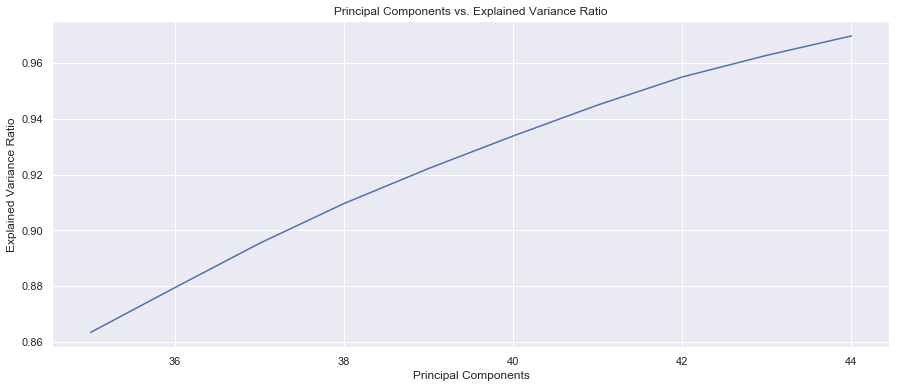

In [27]:
contCol = [cont for cont in list(finaldf.columns) if cont not in catCols]
X_cont = X[contCol]

scaler = StandardScaler()
scaler.fit(X_cont)
X_norm = scaler.transform(X_cont)


#X_norm = preprocessing.normalize(X)
pComp = list(range(35, 45))
varExp = []
for n in pComp:
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(X_norm)
    varExp.append(np.sum(pca.explained_variance_ratio_))
plt.figure(figsize=(15, 6))
plt.plot(pComp, varExp)
plt.title("Principal Components vs. Explained Variance Ratio")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

With 42/58 of the continuous features, 95% of the variance can be explained in the data.

# Gradient Boosting and Hyperparameter Tuning

In [62]:
paramGrid = {'max_depth': np.arange(4, 13), 'reg_alpha': np.arange(0.1, 1, 0.1),
             'reg_lambda': np.arange(0.01, 1, 0.05), "num_leaves": np.arange(2, 30),
             'min_child_weight': [1e-4, 1e-3, 1e-2, 1e-1], 
            'subsample': np.arange(0.01, 1, 0.05), 'learning_rate': [0.001, .01, .1],
            "boosting": ["dart", "gbdt"], "objective": ["binary"]}
grid2 = RandomizedSearchCV(lgb.LGBMClassifier(), paramGrid, cv=3)
grid2.fit(X_train, y_train)
lgbr = grid2.best_estimator_
pd.DataFrame(grid2.cv_results_)

C:\Users\Owner\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Owner\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Owner\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Owner\Miniconda3\lib\site-packages\sklearn\

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_objective,param_num_leaves,param_min_child_weight,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,15.651646,4.013052,1.551521,0.135067,0.76,0.51,0.4,binary,11,0.01,...,0.973418,0.973262,0.973260,0.000130,3,0.973446,0.973272,0.973496,0.973405,0.000096
1,9.599327,1.067914,1.624655,0.050205,0.56,0.16,0.5,binary,28,0.1,...,0.975194,0.974826,0.974962,0.000165,1,0.975545,0.975424,0.975560,0.975510,0.000061
2,15.694234,2.086578,1.187824,0.113129,0.66,0.96,0.3,binary,22,0.1,...,0.969982,0.969089,0.969378,0.000427,5,0.969359,0.969785,0.969450,0.969531,0.000183
3,7.788837,0.495513,1.084765,0.042232,0.31,0.11,0.6,binary,19,0.1,...,0.923842,0.923847,0.923844,0.000002,8,0.923844,0.923844,0.923842,0.923844,0.000001
4,6.478007,0.536534,1.165882,0.074156,0.21,0.71,0.2,binary,9,0.1,...,0.973908,0.973655,0.973716,0.000139,2,0.973908,0.973792,0.973928,0.973876,0.000060
5,7.248282,0.035879,1.067812,0.004017,0.66,0.91,0.1,binary,23,0.001,...,0.971773,0.971233,0.971430,0.000244,4,0.971486,0.971632,0.971576,0.971565,0.000060
6,15.075019,3.724275,1.416213,0.468348,0.06,0.06,0.4,binary,12,0.1,...,0.966667,0.965138,0.964864,0.001596,6,0.963193,0.966187,0.965557,0.964979,0.001289
7,7.770218,1.364197,1.156243,0.132653,0.66,0.76,0.9,binary,3,0.01,...,0.951852,0.951392,0.951512,0.000244,7,0.951622,0.951342,0.951572,0.951512,0.000122
8,9.173803,0.329830,0.951120,0.006584,0.56,0.51,0.1,binary,13,0.1,...,0.923842,0.923847,0.923844,0.000002,8,0.923844,0.923844,0.923842,0.923844,0.000001
9,7.526205,0.103012,1.081442,0.099949,0.46,0.51,0.1,binary,25,0.0001,...,0.923842,0.923847,0.923844,0.000002,8,0.923844,0.923844,0.923842,0.923844,0.000001


In [63]:
param = grid2.best_params_
param["metric"] = "auc"

In [64]:
skf = KFold(n_splits=3)
oof = np.zeros(len(X_train))
predictions = np.zeros((len(X_test),3))
predictionsTrain = np.zeros((len(X_train),3))

i = 1
for train_index, valid_index in skf.split(X_train, y_train):
    print("Fold " + str(i))
    xg_train = lgb.Dataset(X_train.iloc[train_index],
                           label=y_train.iloc[train_index],
                           free_raw_data = False)
    xg_valid = lgb.Dataset(X_train.iloc[valid_index],
                           label=y_train.iloc[valid_index],
                           free_raw_data = False)   
    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid], 
                    verbose_eval=250, early_stopping_rounds = 100)
    oof[valid_index] = clf.predict(X_train.iloc[valid_index], num_iteration=clf.best_iteration) 
    
    predictions[:,i-1] += clf.predict(X_test, num_iteration=clf.best_iteration)
    predictionsTrain[:,i-1] += clf.predict(X_train, num_iteration=clf.best_iteration)
    i = i + 1

Fold 1
Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.934773
Early stopping, best iteration is:
[321]	valid_0's auc: 0.934936
Fold 2
Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.935482
[500]	valid_0's auc: 0.936074
Early stopping, best iteration is:
[592]	valid_0's auc: 0.936311
Fold 3
Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.934165
Early stopping, best iteration is:
[291]	valid_0's auc: 0.934281


In [69]:
dfPred = pd.DataFrame(predictions)
dfPred["final"] = round((dfPred[0] + dfPred[1] + dfPred[2])/3)

In [71]:
#y_pred = gb.predict(X_test)
print(classification_report(y_test.values, dfPred["final"].values))

              precision    recall  f1-score   support

           0       0.99      0.69      0.82     22151
           1       0.98      1.00      0.99    270683

   micro avg       0.98      0.98      0.98    292834
   macro avg       0.98      0.85      0.90    292834
weighted avg       0.98      0.98      0.97    292834



In [73]:
accuracy_score(y_test.values, dfPred["final"].values)

0.9763313003271478

Text(0.5,1,'Confusion Matrix for Gradient Boosting')

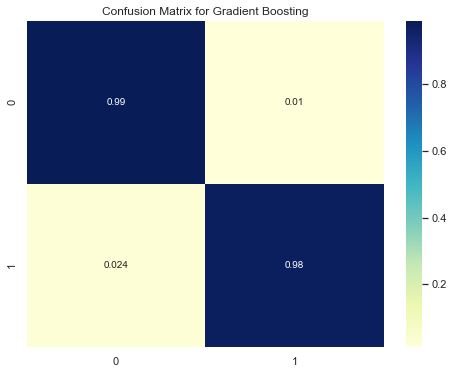

In [74]:
cm = confusion_matrix(dfPred["final"].values, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix for Gradient Boosting")

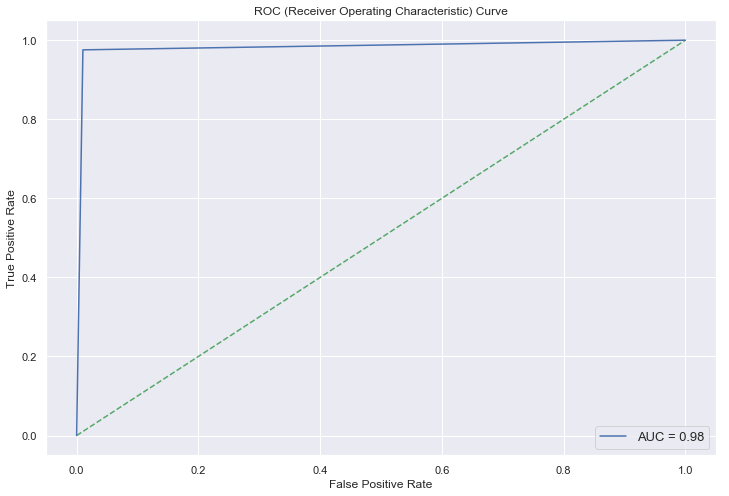

In [77]:
fpr, tpr, threshold = roc_curve(dfPred["final"].values, y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1],'g--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 13})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.show()


# Logistic Regression

In [32]:
lr = LogisticRegression().fit(X_train_sm, y_train_sm)

C:\Users\Owner\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
y_pred = lr.predict(X_test)
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71     22151
           1       0.98      0.97      0.97    270683

   micro avg       0.95      0.95      0.95    292834
   macro avg       0.83      0.86      0.84    292834
weighted avg       0.96      0.95      0.95    292834



In [34]:
accuracy_score(y_test.values, y_pred)

0.9535777949281846

Text(0.5,1,'Confusion Matrix for Logistic Regression')

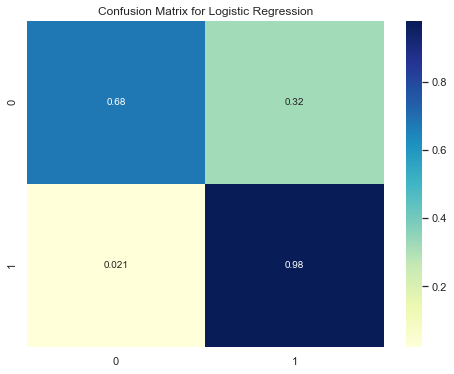

In [61]:
cm = confusion_matrix(y_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix for Logistic Regression")

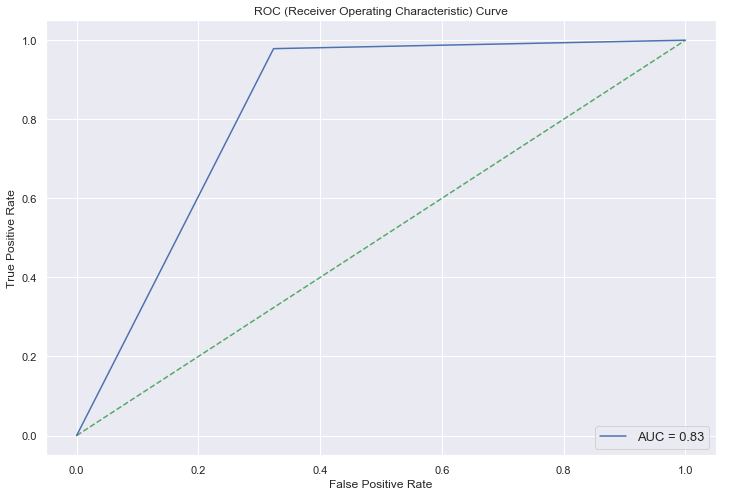

In [72]:
fpr, tpr, threshold = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1],'g--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 13})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.show()

# KNN

In [35]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_sm, y_train_sm)

In [73]:
y_pred = knn.predict(X_test)
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.71      0.47     22151
           1       0.97      0.89      0.93    270683

   micro avg       0.88      0.88      0.88    292834
   macro avg       0.66      0.80      0.70    292834
weighted avg       0.93      0.88      0.90    292834



In [38]:
accuracy_score(y_test.values, y_pred)

0.8768722211218642

Text(0.5,1,'Confusion Matrix for KNN')

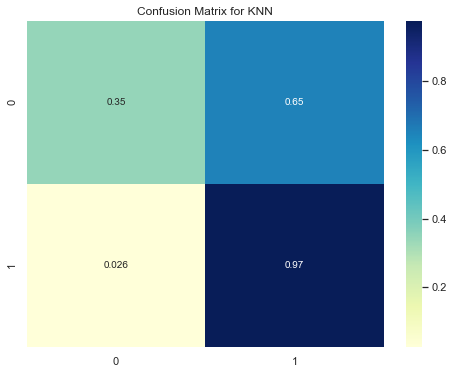

In [63]:
cm = confusion_matrix(y_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix for KNN")

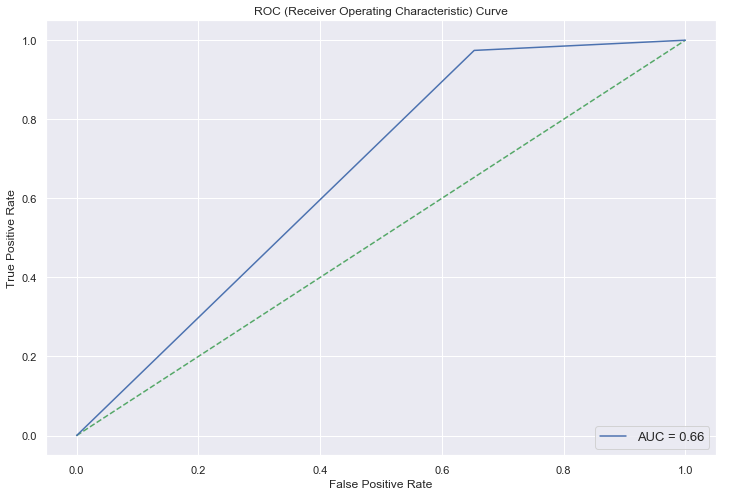

In [74]:
fpr, tpr, threshold = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1],'g--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 13})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.show()

In [39]:
dfFScore = pd.Series(gb.get_booster().get_fscore()).reset_index().rename({"index": "feature", 0: "F Score"}, axis=1)
dfFScore = dfFScore.sort_values("F Score", ascending=False)
dfFScore['rank'] = np.arange(len(dfFScore))+1
display(dfFScore[:10])

,feature,F Score,rank
6,f16,110,1
0,f22,57,2
1,f21,46,3
15,f18,34,4
5,f23,33,5
9,f32,30,6
2,f1,24,7
14,f17,21,8
30,f9,18,9
4,f33,18,10


In [40]:
featureMapping = {"f"+str(ind): col for ind,col in enumerate(X_train.columns)}

In [41]:
dfFScore["featureMapped"] = dfFScore["feature"].apply(lambda x: featureMapping[x])